In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rc("font", family="Arial")
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from pylab import *

import numpy as np
import pyemma
import pytraj as pt
import mdtraj as md

import pickle
import seaborn as sns
from itertools import product
from pandas import DataFrame

from itertools import cycle
import pandas as pd
from os.path import join
from collections import OrderedDict

from pyemma.util.contexts import settings
from glob import glob

from scipy.stats import gaussian_kde

## Create PDB files

In [ ]:
topfile = '../1-Trajectories/0-Parm_rst/open10_dry.parm7'
indir_sample = './sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm'
traj_list_sample = sorted(glob(indir_sample+'/*.xtc'))
for t in traj_list_sample:
    traj=pt.load(t, topfile, stride=1)
    pt.write_traj("./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref{}.pdb".format(t[-10], t[-5]), 
                  traj, overwrite=True, options='model')

In [74]:
topfile = '../1-Trajectories/0-Parm_rst/open10_dry.parm7'
indir_sample = './sample_structures/2-Without_IPA/4-MSM_1000_samples_per_ref'
traj_list_sample = sorted(glob(indir_sample+'/*.xtc'))
for t in traj_list_sample:
    traj=pt.load(t, topfile, stride=1)
    pt.write_traj("./sample_structures/2-Without_IPA/4-MSM_1000_samples_per_ref/pcca{}_ref{}.pdb".format(t[-10], t[-5]), 
                  traj, overwrite=True, options='model')

In [75]:
topfile = '../1-Trajectories/0-Parm_rst/open10_dry.parm7'
indir_sample = './sample_structures/1-With_IPA/4-MSM_1000_samples_per_ref'
traj_list_sample = sorted(glob(indir_sample+'/*.xtc'))
for t in traj_list_sample:
    traj=pt.load(t, topfile, stride=1)
    pt.write_traj("./sample_structures/1-With_IPA/4-MSM_1000_samples_per_ref/pcca{}_ref{}.pdb".format(t[-10], t[-5]), 
                  traj, overwrite=True, options='model')

In [ ]:
topfile = '../1-Trajectories/0-Parm_rst/open10_dry.parm7'
indir_sample = './sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm'
traj_list_sample = sorted(glob(indir_sample+'/*.xtc'))
for t in traj_list_sample:
    traj=pt.load(t, topfile, stride=1)
    pt.write_traj("./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref{}.pdb".format(t[-10], t[-5]), 
                  traj, overwrite=True, options='model')

## Run ppm and parse results

```
#!/bin/bash

for f in *.pdb; do

        name=$(echo "$f" | cut -f 1 -d '.')

        grep -v "ACE" ${name}.pdb > ${name}.tmp; mv ${name}.tmp ${name}.pdb
        grep -v "NHE" ${name}.pdb > ${name}.tmp; mv ${name}.tmp ${name}.pdb
        grep -v "TER" ${name}.pdb > ${name}.tmp; mv ${name}.tmp ${name}.pdb

        ppm_linux_64.exe -pdb ${name}.pdb -pre ${name}.dat -begin 0 -stop 9999 -para pdb
        ppm_linux_64.exe -pdb ${name}.pdb -pre ${name}_old.dat -begin 0 -stop 9999 -para old

        for file in ${name}_CB_pre.dat ${name}_HB_pre.dat ${name}_CB_pre_old.dat ${name}_HB_pre_old.dat; do
                if [ -f $file ] ; then
                        rm $file
                fi
        done

        for i in 14 46 78 110 142 174; do

                grep "${i}      ALA       CB" ${name}.dat | awk '{print $6}' >> ${name}_CB_pre.dat
                grep "${i}      ALA       HB" ${name}.dat | awk '{print $6}' >> ${name}_HB_pre.dat
                grep "${i}      ALA       CB" ${name}_old.dat | awk '{print $6}'  >> ${name}_CB_pre_old.dat
                grep "${i}      ALA       HB" ${name}_old.dat | awk '{print $6}'>> ${name}_HB_pre_old.dat
        done
done

```

## Prediction using ppm_one

### Parse output for ppm_one

This is ugly and should rely on different loops, etc. but I needed to do it quickly and this way was easier and faster

#### Without IPA

In [63]:
CB=[]
HB=[]
# Weights of each reference trajectory (i.e. fraction of ref0, ref1, etc... for each pcca)
weights_ref=[[0.67,0.03,0.21,0.03,0.05,0.00],
[0.69,0.02,0.17,0.04,0.07,0.01],
[0.73,0.02,0.11,0.10,0.04,0.01],
[0.72,0.03,0.03,0.17,0.03,0.02],
[0.40,0.07,0.14,0.20,0.06,0.13],
[0.65,0.04,0.07,0.16,0.04,0.04]]

for i in range(0,6):
    CB_pcca=[]
    HB_pcca=[]
    
    #Ref0
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref0_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[1],a[2],a[3],a[4],a[5],a[0]])*weights_ref[i][0]) # This is so all have the same chain topology

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref0_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[1],a[2],a[3],a[4],a[5],a[0]])*weights_ref[i][0])
    
    #Ref1
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref1_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[2],a[3],a[4],a[5],a[0],a[1]])*weights_ref[i][1])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref1_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[2],a[3],a[4],a[5],a[0],a[1]])*weights_ref[i][1])

    #Ref2
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref2_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[3],a[4],a[5],a[0],a[1],a[2]])*weights_ref[i][2])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref2_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[3],a[4],a[5],a[0],a[1],a[2]])*weights_ref[i][2])
    
    #Ref3
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref3_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[4],a[5],a[0],a[1],a[2],a[3]])*weights_ref[i][3])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref3_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[4],a[5],a[0],a[1],a[2],a[3]])*weights_ref[i][3])
    
    #Ref4
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref4_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[5],a[0],a[1],a[2],a[3],a[4]])*weights_ref[i][4])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref4_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[5],a[0],a[1],a[2],a[3],a[4]])*weights_ref[i][4])
    
    #Ref5
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref5_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[0],a[1],a[2],a[3],a[4],a[5]])*weights_ref[i][5])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref5_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[0],a[1],a[2],a[3],a[4],a[5]])*weights_ref[i][5])
    
    CB.append(np.sum(CB_pcca, axis=0))
    HB.append(np.sum(HB_pcca, axis=0))

#### With IPA

In [64]:
CB_ipa=[]
HB_ipa=[]

weights_ref=[[0.13,0.19,0.12,0.24,0.08,0.23],
[0.65,0.01,0.08,0.16,0.05,0.06],
[0.56,0.02,0.02,0.26,0.04,0.10],
[0.02,0.01,0.48,0.01,0.47,0.01],
[0.25,0.04,0.21,0.23,0.04,0.23]]

for i in range(0,5):
    CB_pcca=[]
    HB_pcca=[]
    
    #Ref0
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref0_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[1],a[2],a[3],a[4],a[5],a[0]])*weights_ref[i][0])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref0_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[1],a[2],a[3],a[4],a[5],a[0]])*weights_ref[i][0])
    
    #Ref1
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref1_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[2],a[3],a[4],a[5],a[0],a[1]])*weights_ref[i][1])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref1_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[2],a[3],a[4],a[5],a[0],a[1]])*weights_ref[i][1])

    #Ref2
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref2_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[3],a[4],a[5],a[0],a[1],a[2]])*weights_ref[i][2])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref2_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[3],a[4],a[5],a[0],a[1],a[2]])*weights_ref[i][2])
    
    #Ref3
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref3_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[4],a[5],a[0],a[1],a[2],a[3]])*weights_ref[i][3])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref3_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[4],a[5],a[0],a[1],a[2],a[3]])*weights_ref[i][3])
    
    #Ref4
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref4_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[5],a[0],a[1],a[2],a[3],a[4]])*weights_ref[i][4])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref4_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[5],a[0],a[1],a[2],a[3],a[4]])*weights_ref[i][4])
    
    #Ref5
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref5_CB_pre.dat".format(i+1))
    CB_pcca.append(np.array([a[0],a[1],a[2],a[3],a[4],a[5]])*weights_ref[i][5])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref5_HB_pre.dat".format(i+1))
    HB_pcca.append(np.array([a[0],a[1],a[2],a[3],a[4],a[5]])*weights_ref[i][5])
    
    CB_ipa.append(np.sum(CB_pcca, axis=0))
    HB_ipa.append(np.sum(HB_pcca, axis=0))

### Plots for ppm_one

#### Without IPA

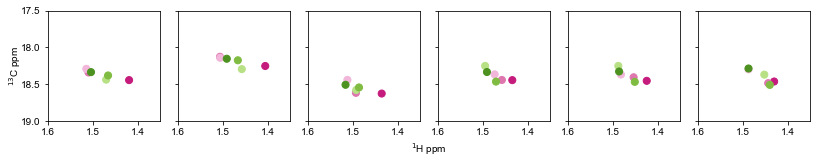

In [40]:
pcca=[1,0,2,3,5,4]
fig, axes = plt.subplots(1, 6, figsize=(12, 2.65), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.scatter(HB[pcca[i]], CB[pcca[i]],s=50,
               c=['#c51b7d','#de77ae','#f1b6da','#b8e186','#7fbc41','#4d9221'])

#     sns.distplot(sasa_all_at_2[pcca[i]][:,at[i]], kde=False, ax=ax, bins=10,norm_hist=False, 
#                  color=colours[i], hist_kws={"alpha": 1})


    ax.set_xlim(1.35,1.6)
# #     ax.set_xticks(np.arange(0, 40, 10))    
    ax.set_ylim(17.5,19)
# #     ax.set_yticks(np.arange(0, 5, 1))     
# #     ax.set_aspect('equal')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# # To have common x and y labels
# # add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)  

plt.xlabel(r'$^{1}$H ppm')
plt.ylabel(r'$^{13}$C ppm')

fig.tight_layout()
fig.savefig('./plots/2-Without_IPA/40_ppm_one_predictions.png', dpi=600)

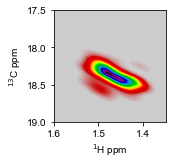

In [68]:
# Weights from stationary distribution of MSM

weights=[[0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620]]


x= np.array(HB).flatten()
y= np.array(CB).flatten()
w= np.array(weights).T.flatten()
# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
kde = gaussian_kde(data,weights=w)

# evaluate on a regular grid
xgrid = np.linspace(1.35,1.6, 100)
ygrid = np.linspace(17.5,19, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.4))
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[1.35,1.6, 17.5,19],
           cmap='nipy_spectral_r')

ax.set_yticks(np.arange(17.5, 19.5, 0.5))
# cb = plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'$^{1}$H ppm')
plt.ylabel(r'$^{13}$C ppm')

fig.tight_layout()
fig.savefig('./plots/2-Without_IPA/41_ppm_one_predictions_density.png', dpi=600)

#### With IPA

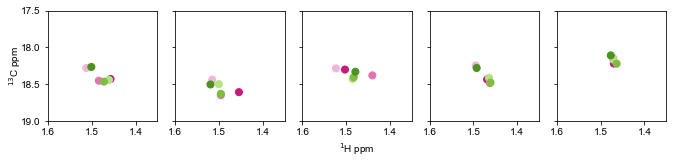

In [56]:
pcca=[2,1,3,4,0]
fig, axes = plt.subplots(1, 5, figsize=(10, 2.65), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.scatter(HB_ipa[pcca[i]], CB_ipa[pcca[i]],s=50,
               c=['#c51b7d','#de77ae','#f1b6da','#b8e186','#7fbc41','#4d9221'])

#     sns.distplot(sasa_all_at_2[pcca[i]][:,at[i]], kde=False, ax=ax, bins=10,norm_hist=False, 
#                  color=colours[i], hist_kws={"alpha": 1})


    ax.set_xlim(1.35,1.6)
# #     ax.set_xticks(np.arange(0, 40, 10))    
    ax.set_ylim(17.5,19)
# #     ax.set_yticks(np.arange(0, 5, 1))     
# #     ax.set_aspect('equal')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# # To have common x and y labels
# # add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)  

plt.xlabel(r'$^{1}$H ppm')
plt.ylabel(r'$^{13}$C ppm')



fig.tight_layout()
fig.savefig('./plots/1-With_IPA/40_ppm_one_predictions.png', dpi=600)

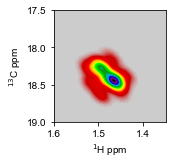

In [69]:
weights_ipa=[[0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779]]

x= np.array(HB_ipa).flatten()
y= np.array(CB_ipa).flatten()
w= np.array(weights_ipa).T.flatten()
# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
kde = gaussian_kde(data,weights=w)

# evaluate on a regular grid
xgrid = np.linspace(1.35,1.6, 100)
ygrid = np.linspace(17.5,19, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.4))
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[1.35,1.6, 17.5,19],
           cmap='nipy_spectral_r')

ax.set_yticks(np.arange(17.5, 19.5, 0.5))
# cb = plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'$^{1}$H ppm')
plt.ylabel(r'$^{13}$C ppm')

fig.tight_layout()
fig.savefig('./plots/1-With_IPA/41_ppm_one_predictions_density.png', dpi=600)

## Predictions for ppm_old

### Parse output for ppm_old

#### Without IPA

In [70]:
CB=[]
HB=[]

weights_ref=[[0.67,0.03,0.21,0.03,0.05,0.00],
[0.69,0.02,0.17,0.04,0.07,0.01],
[0.73,0.02,0.11,0.10,0.04,0.01],
[0.72,0.03,0.03,0.17,0.03,0.02],
[0.40,0.07,0.14,0.20,0.06,0.13],
[0.65,0.04,0.07,0.16,0.04,0.04]]

for i in range(0,6):
    CB_pcca=[]
    HB_pcca=[]
    
    #Ref0
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref0_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[1],a[2],a[3],a[4],a[5],a[0]])*weights_ref[i][0])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref0_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[1],a[2],a[3],a[4],a[5],a[0]])*weights_ref[i][0])
    
    #Ref1
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref1_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[2],a[3],a[4],a[5],a[0],a[1]])*weights_ref[i][1])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref1_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[2],a[3],a[4],a[5],a[0],a[1]])*weights_ref[i][1])

    #Ref2
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref2_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[3],a[4],a[5],a[0],a[1],a[2]])*weights_ref[i][2])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref2_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[3],a[4],a[5],a[0],a[1],a[2]])*weights_ref[i][2])
    
    #Ref3
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref3_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[4],a[5],a[0],a[1],a[2],a[3]])*weights_ref[i][3])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref3_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[4],a[5],a[0],a[1],a[2],a[3]])*weights_ref[i][3])
    
    #Ref4
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref4_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[5],a[0],a[1],a[2],a[3],a[4]])*weights_ref[i][4])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref4_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[5],a[0],a[1],a[2],a[3],a[4]])*weights_ref[i][4])
    
    #Ref5
    
    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref5_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[0],a[1],a[2],a[3],a[4],a[5]])*weights_ref[i][5])

    a=np.loadtxt(fname="./sample_structures/2-Without_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref5_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[0],a[1],a[2],a[3],a[4],a[5]])*weights_ref[i][5])
    
    CB.append(np.sum(CB_pcca, axis=0))
    HB.append(np.sum(HB_pcca, axis=0))

#### With IPA

In [71]:

CB_ipa=[]
HB_ipa=[]

weights_ref=[[0.13,0.19,0.12,0.24,0.08,0.23],
[0.65,0.01,0.08,0.16,0.05,0.06],
[0.56,0.02,0.02,0.26,0.04,0.10],
[0.02,0.01,0.48,0.01,0.47,0.01],
[0.25,0.04,0.21,0.23,0.04,0.23]]

for i in range(0,5):
    CB_pcca=[]
    HB_pcca=[]
    
    #Ref0
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref0_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[1],a[2],a[3],a[4],a[5],a[0]])*weights_ref[i][0])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref0_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[1],a[2],a[3],a[4],a[5],a[0]])*weights_ref[i][0])
    
    #Ref1
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref1_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[2],a[3],a[4],a[5],a[0],a[1]])*weights_ref[i][1])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref1_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[2],a[3],a[4],a[5],a[0],a[1]])*weights_ref[i][1])

    #Ref2
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref2_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[3],a[4],a[5],a[0],a[1],a[2]])*weights_ref[i][2])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref2_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[3],a[4],a[5],a[0],a[1],a[2]])*weights_ref[i][2])
    
    #Ref3
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref3_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[4],a[5],a[0],a[1],a[2],a[3]])*weights_ref[i][3])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref3_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[4],a[5],a[0],a[1],a[2],a[3]])*weights_ref[i][3])
    
    #Ref4
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref4_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[5],a[0],a[1],a[2],a[3],a[4]])*weights_ref[i][4])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref4_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[5],a[0],a[1],a[2],a[3],a[4]])*weights_ref[i][4])
    
    #Ref5
    
    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref5_CB_pre_old.dat".format(i+1))
    CB_pcca.append(np.array([a[0],a[1],a[2],a[3],a[4],a[5]])*weights_ref[i][5])

    a=np.loadtxt(fname="./sample_structures/1-With_IPA/6-MSM_10000_samples_per_ref_for_ppm/pcca{}_ref5_HB_pre_old.dat".format(i+1))
    HB_pcca.append(np.array([a[0],a[1],a[2],a[3],a[4],a[5]])*weights_ref[i][5])
    
    CB_ipa.append(np.sum(CB_pcca, axis=0))
    HB_ipa.append(np.sum(HB_pcca, axis=0))

### Plots for ppm_old

#### Without IPA

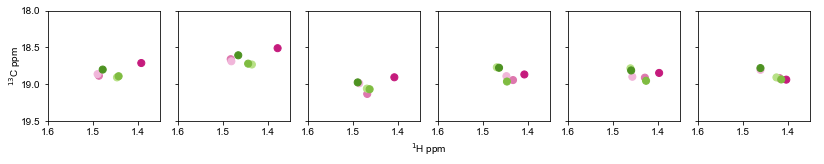

In [53]:
pcca=[1,0,2,3,5,4]
fig, axes = plt.subplots(1, 6, figsize=(12, 2.65), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.scatter(HB[pcca[i]], CB[pcca[i]],s=50,
               c=['#c51b7d','#de77ae','#f1b6da','#b8e186','#7fbc41','#4d9221'])

#     sns.distplot(sasa_all_at_2[pcca[i]][:,at[i]], kde=False, ax=ax, bins=10,norm_hist=False, 
#                  color=colours[i], hist_kws={"alpha": 1})


    ax.set_xlim(1.35,1.6) 
    ax.set_ylim(18,19.5)
#     ax.set_xticks(np.arange(0, 40, 10)) 
#     ax.set_yticks(np.arange(0, 5, 1))     
#     ax.set_aspect('equal')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# # To have common x and y labels
# # add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)  

plt.xlabel(r'$^{1}$H ppm')
plt.ylabel(r'$^{13}$C ppm')

fig.tight_layout()
fig.savefig('./plots/2-Without_IPA/42_ppm_old_predictions.png', dpi=600)

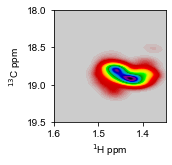

In [72]:
# Weights from stationary distribution of MSM

weights=[[0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620],
         [0.018,0.074,0.040,0.053,0.196,0.620]]


x= np.array(HB).flatten()
y= np.array(CB).flatten()
w= np.array(weights).T.flatten()
# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
kde = gaussian_kde(data,weights=w)
# evaluate on a regular grid
xgrid = np.linspace(1.35,1.6, 100)
ygrid = np.linspace(18,19.5, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.4))
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[1.35,1.6, 18,19.5],
           cmap='nipy_spectral_r')

ax.set_yticks(np.arange(18,20, 0.5))
# cb = plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'$^{1}$H ppm')
plt.ylabel(r'$^{13}$C ppm')

fig.tight_layout()
fig.savefig('./plots/2-Without_IPA/43_ppm_old_predictions_density.png', dpi=600)

#### With IPA

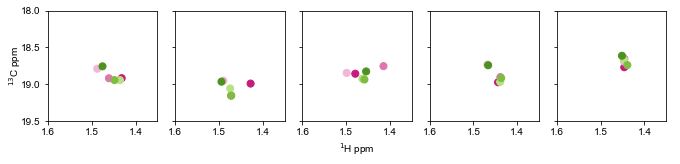

In [60]:
pcca=[2,1,3,4,0]
fig, axes = plt.subplots(1, 5, figsize=(10, 2.65), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.scatter(HB_ipa[pcca[i]], CB_ipa[pcca[i]],s=50,
               c=['#c51b7d','#de77ae','#f1b6da','#b8e186','#7fbc41','#4d9221'])

#     sns.distplot(sasa_all_at_2[pcca[i]][:,at[i]], kde=False, ax=ax, bins=10,norm_hist=False, 
#                  color=colours[i], hist_kws={"alpha": 1})


    ax.set_xlim(1.35,1.6) 
    ax.set_ylim(18,19.5)
#     ax.set_xticks(np.arange(0, 40, 10))  
#     ax.set_yticks(np.arange(0, 5, 1))     
#     ax.set_aspect('equal')

plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

# # To have common x and y labels
# # add a big axis, hide frame
fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)  

plt.xlabel(r'$^{1}$H ppm')
plt.ylabel(r'$^{13}$C ppm')



fig.tight_layout()
fig.savefig('./plots/1-With_IPA/42_ppm_old_predictions.png', dpi=600)

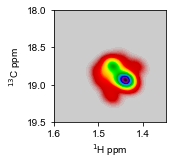

In [73]:
weights_ipa=[[0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779],
             [0.029693,0.099180,0.194989,0.162358,0.513779]]

x= np.array(HB_ipa).flatten()
y= np.array(CB_ipa).flatten()
w= np.array(weights_ipa).T.flatten()
# fit an array of size [Ndim, Nsamples]
data = np.vstack([x, y])
kde = gaussian_kde(data,weights=w)

# evaluate on a regular grid
xgrid = np.linspace(1.35,1.6, 100)
ygrid = np.linspace(18,19.5, 100)
Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

# Plot the result as an image
fig, ax = plt.subplots(1, 1, figsize=(2.5, 2.4))
plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[1.35,1.6, 18,19.5],
           cmap='nipy_spectral_r')

ax.set_yticks(np.arange(18,20, 0.5))
# cb = plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()

plt.xlabel(r'$^{1}$H ppm')
plt.ylabel(r'$^{13}$C ppm')
fig.tight_layout()
fig.savefig('./plots/1-With_IPA/43_ppm_old_predictions_density.png', dpi=600)